# Сборный проект — 2

# Задача. 
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании, уровнем удовлетворённости сотрудника работой в компании: 
0 — совершенно неудовлетворён
1 — полностью удовлетворён. 

# Первая задача
Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Обоснование: 
-удовлетворённость работой напрямую влияет на отток сотрудников
-предсказание оттока — одна из важнейших задач HR-аналитиков
-внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

# Задача 1: Предсказание уровня удовлетворённости сотрудника
Заказчик предоставил данные с признаками:
•	id — уникальный идентификатор сотрудника;
•	dept — отдел, в котором работает сотрудник;
•	level — уровень занимаемой должности;
•	workload — уровень загруженности сотрудника;
•	employment_years — длительность работы в компании (в годах);
•	last_year_promo — показывает, было ли повышение за последний год;
•	last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
•	supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
•	salary — ежемесячная зарплата сотрудника;
•	job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

#  Шаг 1. Загрузка данных

Загрузите файлы с данными:
Тренировочная выборка:
train_job_satisfaction_rate.csv
Входные признаки тестовой выборки:
test_features.csv
Целевой признак тестовой выборки:
test_target_job_satisfaction_rate.csv

In [1]:
!pip install -q phik
!pip install -q --upgrade scikit-learn
!pip install seaborn
%pip install --upgrade pip

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

from phik import phik_matrix
from scipy.stats import mstats, pearsonr

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, QuantileTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

from sklearn.datasets import make_classification

In [3]:
# Пути к файлам
local_path = 'C:/GitProjects/supervised_learning_project/data/task1/train1/train_job_satisfaction_rate.csv'
server_path = '/datasets/train_job_satisfaction_rate.csv'

# Инициализация переменной для хранения данных
data_train = None

# Проверка существования файлов и загрузка данных
try:
    if os.path.exists(local_path):
        data_train = pd.read_csv(local_path)
        print("Данные загружены с локального пути.")
    elif os.path.exists(server_path):
        data_train = pd.read_csv(server_path)
        print("Данные загружены с серверного пути.")
    else:
        raise FileNotFoundError("Файл не найден ни по локальному, ни по серверному пути.")
    
    # Выводим имена столбцов
    print("Имена столбцов:", data_train.columns.tolist())

    # нет столбца с датами, просто загружаем данные без parse_dates
    # используем index_col для индекса
    data_train = pd.read_csv(local_path, index_col='id')
    
except Exception as e:
    print(f"Произошла ошибка: {e}")

# Вывод первых 5 строк данных, если данные были загружены
if data_train is not None:
    display(data_train.head())
else:
    print("Нет данных для отображения.")

Данные загружены с локального пути.
Имена столбцов: ['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
# Изучение структуры данных
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None


Тренировочная выборка data_train состоит из 4000 записей с 10 признаками, содержит пропущенные значения в столбцах dept - 6 и level - 4, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми. 

Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по  2 уникальных значения.

Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000, job_satisfaction_rate - от 0 до 1,0.

Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [5]:
# Входные признаки тестовой выборки
data_test = pd.read_csv('C:/GitProjects/supervised_learning_project/data/task1/test1/test_features.csv')

# Выводим первые 5 строк данных
display(data_test.head())

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/test_features.csv'

In [ ]:
# Изучение структуры данных
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


Тестовая выборка data_test состоит из 2000 записей с 9 признаками, содержит пропущенные значения в столбцах dept - 2 и level - 1, их можно обработать с помощью методов заполнения, таких как среднее или мода. Все признаки являются категориальными или числовыми. 

Анализ категориальных признаков: dept имеет 5 уникальных значения, level - 3, workload - 3, last_year_promo и last_year_violations - по  2 уникальных значения.

Анализ числовых признаков: employment_years варьируется от 1 до 10 лет, supervisor_evaluation - от 1 до 5, salary - от 10000 до 100000.

Набор данных хорошо структурирован и содержит минимальное количество пропущенных значений. Категориальные признаки имеют ограниченное количество уникальных значений, что упрощает их обработку. Числовые признаки имеют разумные диапазоны и распределения. Нет явных проблем с корреляцией между признаками. В целом, набор данных находится в хорошем состоянии и готов к дальнейшему анализу.

In [ ]:
# Целевой признак тестовой выборки
data_target = pd.read_csv('C:/GitProjects/supervised_learning_project/data/task1/test1/test_target_job_satisfaction_rate.csv')

# Выводим первые 5 строк данных
display(data_target.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [ ]:
# Изучение структуры данных
print(data_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


Целевой признак тестовой выборки data_target состоит из 2000 записей с 2 признаками, не содержит пропущенных значений. 

Анализ числовых признаков: job_satisfaction_rate варьируется  от 0 до 1,0.

Набор данных хорошо структурирован и не содержит пропущенных значений. Числовые признаки имеют определенный диапазон и распределение, целевой признак тестовой выборки находится в хорошем состоянии и готов к дальнейшему анализу.

#  Шаг 2. Предобработка данных

Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [ ]:
# Проверяем наличие дубликатов в data_train
data_train.duplicated().sum()

0

In [ ]:
# Проверяем наличие дубликатов data_test
data_test.duplicated().sum()

0

In [ ]:
# Проверяем наличие дубликатов data_target
data_target.duplicated().sum()

0

In [ ]:
# Проверка на наличие пропусков в data_train
missing_values = data_train.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Признаки dept и level имеют небольшое количество пропусков (15% и 10% соответственно), что не может сильно повлиять на анализ. Для признаков dept и level можно рассмотреть возможность обработки готовыми реализованными инструментами библиотек с методом fit transform.

In [ ]:
# Проверка на наличие пропусков в data_test
missing_values = data_test.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [ ]:
# Проверка на наличие пропусков в data_target
missing_values = data_target.isnull().sum()
display("Пропуски в данных:\n", missing_values)

'Пропуски в данных:\n'

id                       0
job_satisfaction_rate    0
dtype: int64

In [ ]:
# Получаем уникальные значения для категориальных признаков data_train
for col in data_train.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_train[col].unique())
    display()

Уникальные значения для столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца workload:
['medium' 'high' 'low']
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [ ]:
# Заменяем 'sinior' на 'senior' в столбце 'level'
data_train['level'] = data_train['level'].replace('sinior', 'senior')

# Проверяем изменения
print(data_train['level'].value_counts())

junior    1894
middle    1744
senior     358
Name: level, dtype: int64


In [ ]:
# Получаем уникальные значения для категориальных признаков data_test
for col in data_test.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_test[col].unique())
    display()

Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения для столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' ' ']
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [ ]:
# Заменяем 'sinior' на 'senior' в столбце 'level'
data_test['level'] = data_test['level'].replace('sinior', 'senior')

# Проверяем изменения
print(data_test['level'].value_counts())

# Заменяем пробелы на np.nan для всех категориальных признаков
for col in data_test.select_dtypes(include=['object']).columns:
    data_test[col] = data_test[col].replace(' ', np.nan)

# Проверяем уникальные значения после замены
for col in data_test.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_test[col].unique())

junior    974
middle    854
senior    171
Name: level, dtype: int64
Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


# Проведена проверка на пропуски и дубликаты
Пропуски в data_train: dept - 6, level - 4, в data_test: dept - 2, level - 1 и дубликатов нет. В уникальных значениях для категориальных признаков data_train dept - nan, level - nan, в data_test: dept - ' ', level - nan, workload - ' '.

#  Шаг 3. Исследовательский анализ данных

Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.

In [ ]:
# Исключаем столбец 'id' из описательной статистики
data_train = data_train.drop(columns=['id'])

# Выполняем описательный анализ
display(data_train.describe())

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


# employmentyears
Средний стаж работы составляет немного более 3.5 лет - высокая текучесть кадров, многие сотрудники относительно новички. Максимальный стаж в 10 лет говорит о наличии и опытных работников в компании.

# supervisorevaluation
Переменная имеет значения в диапазоне от 1 до 5, где средняя оценка составляет примерно 3.5 - в компании есть некоторые проблемы с оценкой сотрудников, если большинство оценок сосредоточено около средней отметки.

# salary
Средняя зарплата значительно ниже максимального значения, что указывает на большую вариативность в уровнях заработной платы среди сотрудников. Наличие зарплат на уровне 12000 может свидетельствовать о более низких должностях или о значительном разбросе по уровням квалификации.

# jobsatisfactionrate
Средний уровень удовлетворенности работой составляет 0.53, что может быть интерпретировано как умеренный уровень удовлетворенности. Однако наличие минимального значения 0.03 указывает на то, что некоторые сотрудники крайне недовольны своей работой.

Данные показывают разнообразие в стаже работы, зарплатах и удовлетворенности сотрудников. Вариативность зарплат и низкий уровень удовлетворенности подтверждают необходимость исследовать причины такого положения.

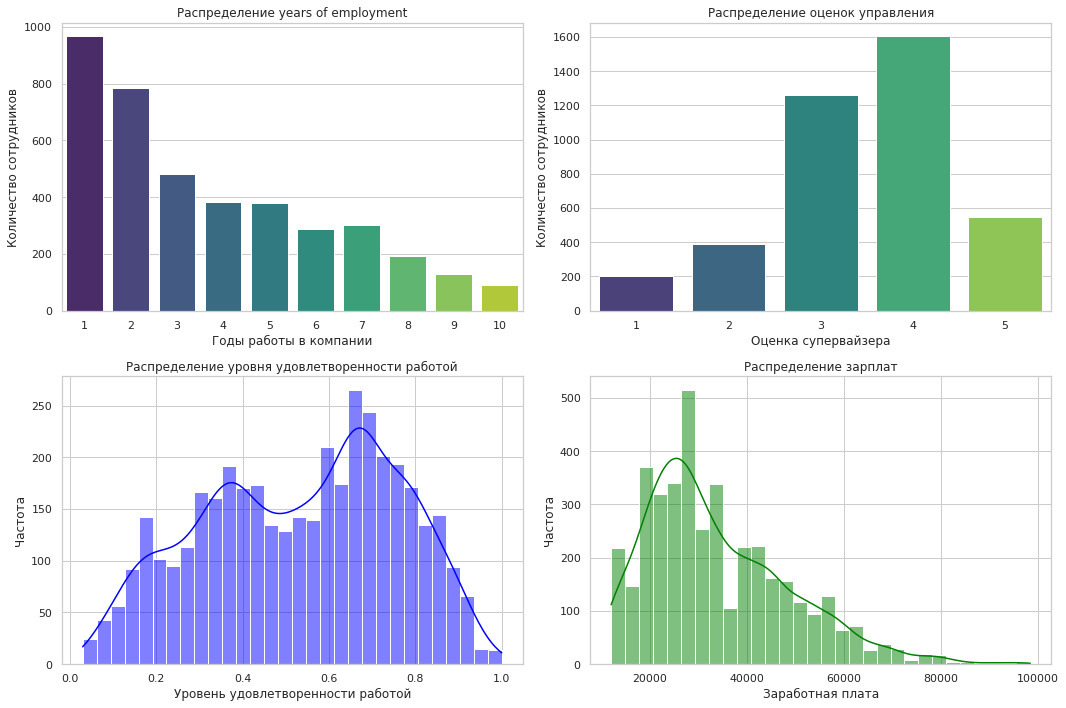

In [ ]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем фигуру для графиков
plt.figure(figsize=(15, 10))

# Для дискретных признаков
plt.subplot(2, 2, 1)  # График 1: employment_years
sns.countplot(x='employment_years', data=data_train, palette='viridis')
plt.title('Распределение years of employment')  # Название графика
plt.xlabel('Годы работы в компании')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 2)  # График 2: supervisor_evaluation
sns.countplot(x='supervisor_evaluation', data=data_train, palette='viridis')
plt.title('Распределение оценок управления')  # Название графика
plt.xlabel('Оценка супервайзера')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

# Для непрерывных признаков
plt.subplot(2, 2, 3)  # График 3: job_satisfaction_rate
sns.histplot(data_train['job_satisfaction_rate'], bins=30, kde=True, color='blue')
plt.title('Распределение уровня удовлетворенности работой')  # Название графика
plt.xlabel('Уровень удовлетворенности работой')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.subplot(2, 2, 4)  # График 4: salary
sns.histplot(data_train['salary'], bins=30, kde=True, color='green')
plt.title('Распределение зарплат')  # Название графика
plt.xlabel('Заработная плата')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.tight_layout()  # Улучшает внешний вид графиков
plt.show()

# Коэффициенты асимметрии
1.employment_years = (3.718500 - 3,0) / 2.542513 = 0,28 - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников с небольшим стажем, опытных сотрудников около 200 человек.
2.supervisor_evaluation = (3.476500 - 4,0) / 1.008812 = -0,52 - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую оценку руководителя, у небольшой группы - очень низкая.
3.salary = (33926.7 - 30000) / 14900.7 = 0,26 - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников имеют низкую зарплату, у небольшой группы сотрудников очень высокая зарплата.
4.job_satisfaction_rate = (0.533995 - 0,56) / 0.225327 = -0,13 - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую удовлетворенность работой, у небольшой группы - очень низкая.

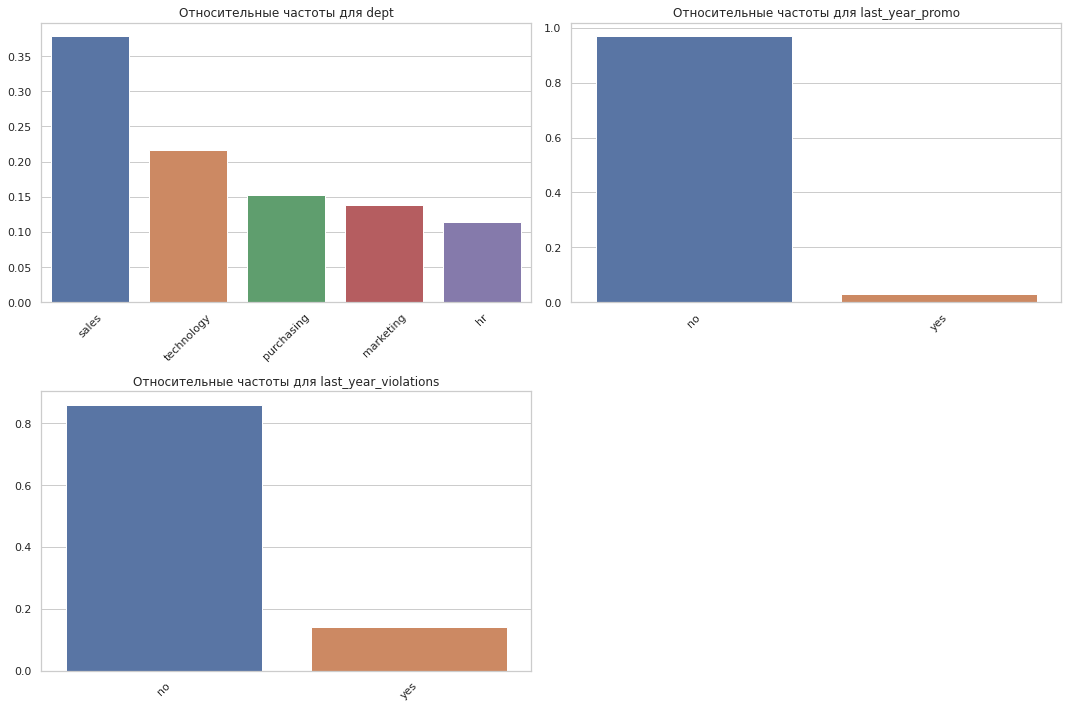

In [ ]:
# Категориальные признаки data_train в относительных показателях
categorical_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Анализ и визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    # Получаем относительные частоты
    relative_freq = data_train[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

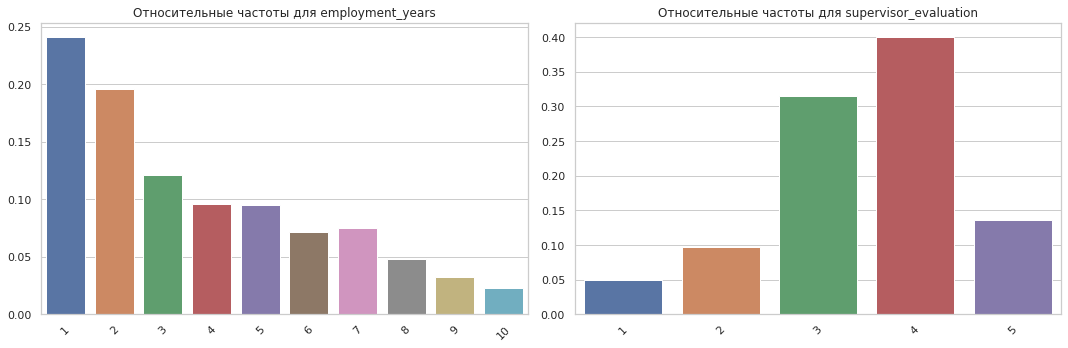

In [ ]:
# Дискретные признаки data_train в относительных показателях
discrete_cols = ['employment_years', 'supervisor_evaluation']

# Анализ и визуализация
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(1, 2, i)
    # Получаем относительные частоты
    relative_freq = data_train[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Оценка удовлетворенности работой

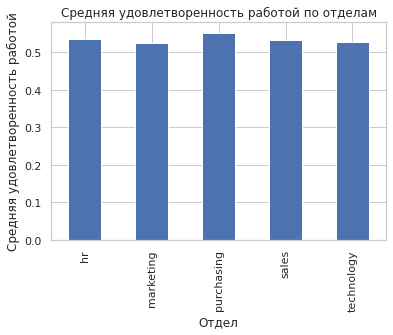

In [ ]:
# Группируем данные по отделам и вычисляем среднюю удовлетворенность
data_train.groupby('dept')['job_satisfaction_rate'].mean().plot.bar()

# Добавляем заголовок и метки осей
plt.title('Средняя удовлетворенность работой по отделам')
plt.xlabel('Отдел')
plt.ylabel('Средняя удовлетворенность работой')

plt.show()

In [ ]:
# Создаем сводную таблицу для распределения удовлетворенности работой по отделам и уровням
pivot_table = pd.pivot_table(
    data_train,
    values='job_satisfaction_rate',  # Столбец с удовлетворенностью
    index='dept',                     # Индекс - отдел
    columns='level',                  # Столбцы - уровни
    aggfunc='mean',                   # Функция агрегации - среднее значение
    fill_value=0                      # Заменяем NaN на 0
)

# Выводим сводную таблицу
print("Сводная таблица по удовлетворенности работой:")
display(pivot_table)

Сводная таблица по удовлетворенности работой:


level,junior,middle,senior
dept,,,
hr,0.501193,0.567720,0.565333
marketing,0.544111,0.504890,0.503774
purchasing,0.547372,0.554084,0.566364
sales,0.513013,0.563724,0.485349
technology,0.519341,0.533053,0.531974


Уровень удовлетворенности среди сотрудников варьируется в зависимости от департамента и уровня. В большинстве случаев уровень удовлетворенности выше у сотрудников junior и middle по сравнению с senior, что может указывать на возможные проблемы или ожидания у более опытных сотрудников.

Наиболее удовлетворенные группы:

   • Purchasing (Закупки). Уровень удовлетворенности выше всего среди всех уровней: junior (0.547372), middle (0.554084), senior (0.566364). Это может свидетельствовать о положительной атмосфере и хороших условиях работы в этом департаменте.

   
Наименее удовлетворенные группы:

   • Sales (Продажи). У senior уровень удовлетворенности значительно ниже (0.485349), чем у junior (0.514569) и middle (0.563724). Это может указывать на высокие ожидания или стрессовые условия работы для более опытных сотрудников.

   
Тенденции по уровням:

   • Для большинства департаментов уровень удовлетворенности у junior сотрудников выше или сопоставим с уровнем middle, но значительно ниже у senior. Это может указывать на то, что с увеличением опыта и ответственности, сотрудники сталкиваются с новыми вызовами, которые могут снижать их удовлетворенность.

Департамент HR:

   • Уровень удовлетворенности в HR для junior (0.501193) и senior (0.565333) находится в среднем диапазоне, но middle (0.567720) показывает лучший результат. Это может свидетельствовать о том, что средний уровень сотрудников более удовлетворен своей работой, возможно, из-за лучших возможностей для развития или поддержки.

Необходимо провести дополнительный анализ причин низкой удовлетворенности среди senior сотрудников, особенно в департаменте Sales. Возможно, стоит рассмотреть возможность улучшения условий труда или поддержки для этой группы, создание программ поддержки для senior сотрудников, чтобы помочь им справляться с нагрузками и повышать их удовлетворенность.

# Оценка уровня сотрудников

In [ ]:
# Распределение по количеству сотрудников по уровням в каждом отделе
count_table = pd.pivot_table(
    data_train,
    values='job_satisfaction_rate',  # Используем job_satisfaction_rate для подсчета
    index='dept',                     # Индекс - отдел
    columns='level',                  # Столбцы - уровни
    aggfunc='count',                  # Функция агрегации - подсчет количества
    fill_value=0                      # Заменяем NaN на 0
)

# Выводим таблицу количества сотрудников
print("\nСводная таблица по количеству сотрудников по уровням:")
display(count_table)


Сводная таблица по количеству сотрудников по уровням:


level,junior,middle,senior
dept,,,
hr,218,193,45
marketing,270,227,53
purchasing,293,262,55
sales,697,682,129
technology,410,380,76


Наибольшее количество сотрудников находится в департаменте Sales (1618 сотрудников), что может указывать на высокую значимость этого отдела для компании. Департамент Purchasing также имеет значительное количество сотрудников (610), что может говорить о важности закупок для бизнеса.

Структура уровней:

   • Junior уровень. В большинстве департаментов junior сотрудники составляют наибольшую группу. Например, в Sales их 707, а в Marketing — 270. Это может свидетельствовать о том, что компании активно нанимают новых специалистов и развивают их.

   • Middle уровень также представлен достаточно сильно, особенно в Purchasing (262) и Sales (682). Это говорит о наличии опытных специалистов, которые могут брать на себя ответственность и управлять junior сотрудниками.

   • Senior уровень. Senior сотрудники представлены в меньшинстве во всех департаментах. Например, в HR их всего 45, а в Purchasing — 55. Это может указывать на возможные проблемы с удержанием или развитием талантов на высоких уровнях.

Соотношение уровней:

   • В большинстве департаментов наблюдается значительное преобладание junior сотрудников над senior. Например, в Sales соотношение junior к senior составляет примерно 5,5:1, а в Marketing — около 5:1. Это может указывать на необходимость более активного развития и продвижения сотрудников по карьерной лестнице.

   • В Purchasing соотношение junior к senior составляет примерно 5,3:1, что также подтверждает вышеуказанную тенденцию.

▎Рекомендации:

1. Развитие карьерных путей. Необходимо разработать программы карьерного роста для junior и middle сотрудников, чтобы повысить их мотивацию и удовлетворенность работой, а также увеличить количество senior специалистов.

2. Удержание талантов. Важно обратить внимание на причины низкого количества senior сотрудников и разработать стратегии удержания талантов, например, через обучение, менторство и программы повышения квалификации.

3. Анализ нагрузки. Следует провести анализ нагрузки на middle и senior уровни, чтобы убедиться, что они не перегружены работой, что может быть причиной ухода или низкой удовлетворенности.

4. Оценка потребностей. Регулярно проводить оценку потребностей каждого департамента в кадрах, чтобы обеспечить оптимальное распределение ресурсов и поддержку для роста бизнеса.

# Распределение удовлетворенности работой по отделам и уровням

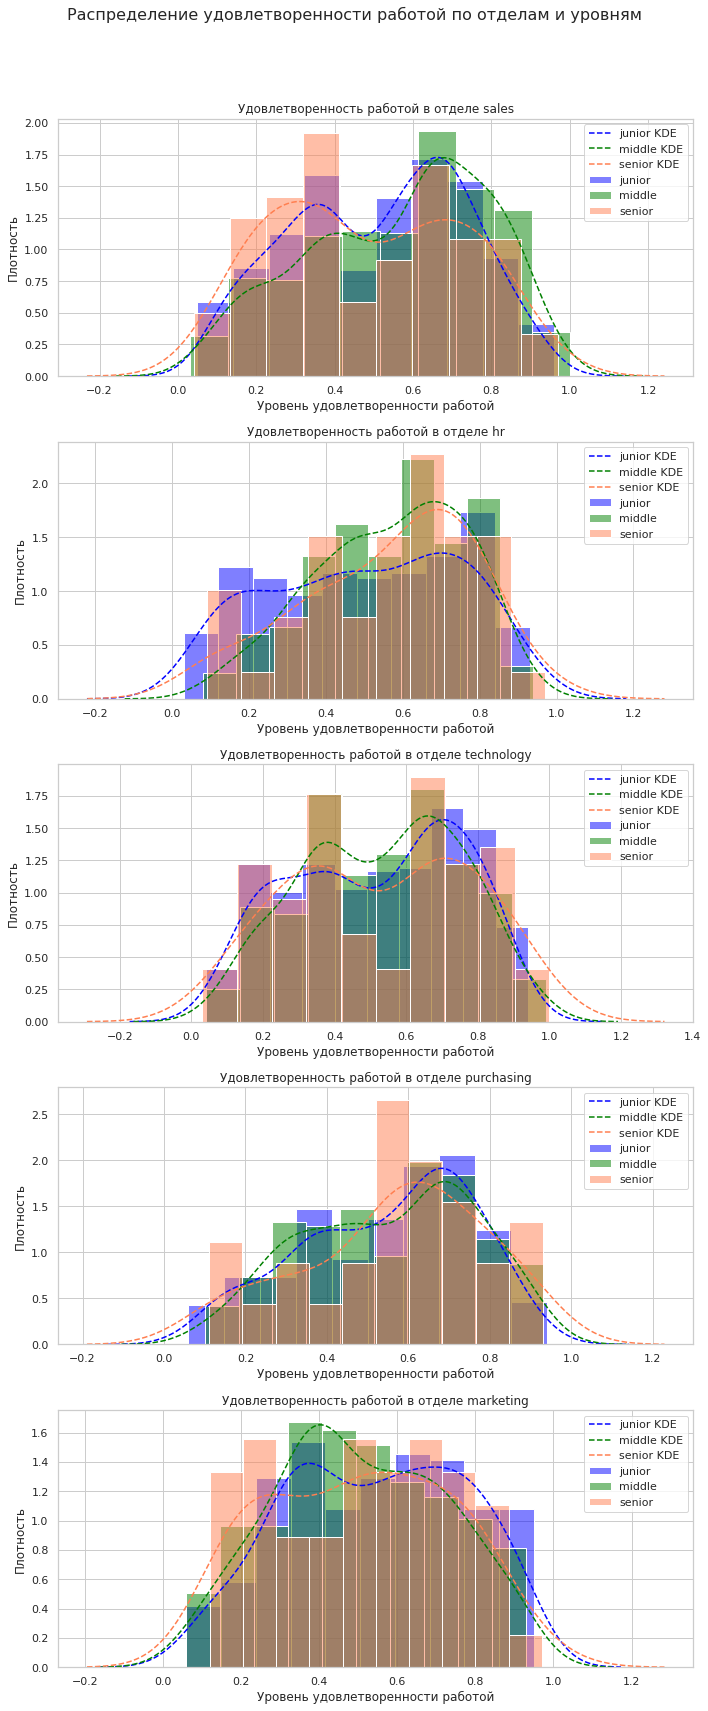

In [ ]:
# Цвета для уровней
level_colors = {'junior': 'blue', 'middle': 'green', 'senior': 'coral'}  # Исправлено 'sinior' на 'senior'

# Уникальные отделы, исключая NaN
departments = data_train['dept'].dropna().unique()

# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=len(departments), ncols=1, figsize=(10, 5 * len(departments)))

# Проходим по каждому отделу и создаем нормированные гистограммы
for ax, dept in zip(axes, departments):
    # Группируем данные по уровням для текущего отдела
    for level in data_train['level'].unique():
        if pd.isna(level):  # Пропускаем NaN значения
            continue
        group = data_train[(data_train['dept'] == dept) & (data_train['level'] == level)]
        
        # Используем нормированную гистограмму
        sns.histplot(group['job_satisfaction_rate'].dropna(), 
                     bins=10, 
                     stat='density', 
                     common_norm=False,
                     alpha=0.5, 
                     label=level, 
                     color=level_colors[level], 
                     ax=ax)
        
        # Также можно добавить график плотности
        sns.kdeplot(group['job_satisfaction_rate'].dropna(), 
                    color=level_colors[level], 
                    ax=ax, 
                    label=f'{level} KDE', 
                    linestyle='--')

    # Настраиваем оси и заголовок для каждого отдела
    ax.set_title(f'Удовлетворенность работой в отделе {dept}')
    ax.set_xlabel('Уровень удовлетворенности работой')
    ax.set_ylabel('Плотность')
    ax.legend()

# Настраиваем общий заголовок для всей фигуры
plt.suptitle('Распределение удовлетворенности работой по отделам и уровням', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Убираем перекрытие заголовка

# Отображаем гистограммы
plt.show()

Уровень удовлетворенности в data_train варьируется в зависимости от отдела и уровня сотрудника.

# Отдел продаж:
Отдел продаж (sales) является самым большим по численности, с 1508 сотрудниками (697 junior, 682 middle, 129 senior) - высокая важность отдела для компании, возможна потребность в большом количестве персонала для достижения бизнес-целей. Уровень удовлетворенности среди junior сотрудников (0.513) и middle (0.564) выглядит приемлемо, однако senior сотрудники имеют самый низкий уровень удовлетворенности среди всех категорий (0.485). Это может указывать на необходимость пересмотра политики мотивации и поддержки старших сотрудников.  Отдел продаж также демонстрирует высокую численность middle сотрудников (682), что может свидетельствовать о необходимости опытных специалистов для управления процессами и наставничества junior сотрудников.  Наименьшее количество senior сотрудников в отделе продаж (129), что может указывать на необходимость более активного развития и удержания опытных специалистов, особенно учитывая высокую нагрузку на отдел.

# Отдел HR:
Уровень удовлетворенности сотрудников в HR-отделе достаточно высок, особенно среди младших (junior) и средних (middle) уровней (0.501 и 0.568 соответственно). Однако уровень удовлетворенности среди старших (senior) сотрудников немного ниже (0.565), что может указывать на необходимость улучшения условий или возможностей для старших специалистов.

# Отдел технологий:
В технологическом отделе уровень удовлетворенности также варьируется, но находится на среднем уровне (junior: 0.519; middle: 0.533; senior: 0.532). Это может говорить о сбалансированном подходе к управлению и поддержке сотрудников.

# Отдел закупок:
Отдел закупок (purchasing) также имеет значительное количество сотрудников (610: 293 junior, 262 middle, 55 senior), что может указывать на сложность и объем работы в этой области. Закупки демонстрируют относительно стабильный уровень удовлетворенности по всем уровням, с небольшими колебаниями, но все уровни находятся выше 0.54. Это может означать, что в этом отделе хорошо организована работа и поддерживается положительная атмосфера. В отделе закупок (262) и маркетинга (227) наблюдается значительное количество middle сотрудников, что может означать наличие структурированных карьерных путей и возможностей для роста внутри этих отделов.

# Отдел маркетинга:
В маркетинговом отделе наблюдается наиболее низкий уровень удовлетворенности среди сотрудников junior (0.544), в то время как уровень удовлетворенности среди middle и senior сотрудников ниже среднего (0.505 и 0.504 соответственно), что может свидетельствовать о проблемах в управлении или рабочей среде в этом отделе. Наибольшее количество junior сотрудников в отделе маркетинга (270), что может говорить о том, что в этом отделе активно развиваются новые кадры или реализуются программы стажировок. Отдел маркетинга имеет 53 senior сотрудника, что также может быть недостаточным для обеспечения стратегического руководства.

Необходимо: 
-проанализировать структуру каждого отдела и определить, достаточно ли senior сотрудников для эффективного управления и наставничества junior и middle уровней.
-провести более глубокий анализ причин низкой удовлетворенности, особенно в отделах маркетинга и продаж для senior сотрудников, изучить обратную связь, выявить конкретные проблемы и области для улучшения.
-внедрить программы развития для старших сотрудников, чтобы повысить их вовлеченность и удовлетворенность. Рассмотреть возможность программ профессионального развития и карьерного роста для junior и middle сотрудников, чтобы повысить их мотивацию и удержание в компании. Обратить внимание на стратегии удержания senior сотрудников, особенно в отделе продаж, чтобы избежать потери опыта и знаний.
-провести сравнительный анализ с предыдущими периодами или аналогичными компаниями, чтобы понять динамику удовлетворенности и выявить тренды.

# Оценка job_satisfaction_rate

Медиана job_satisfaction_rate: 0.56


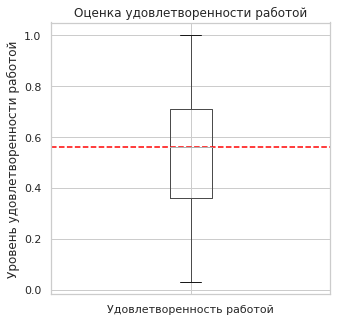

In [ ]:
# Создаем boxplot для job_satisfaction_rate
data_train[['job_satisfaction_rate']].boxplot(figsize=(5, 5))

# Помечаем медиану на графике
median_job_satisfaction_rate = np.median(data_train['job_satisfaction_rate'])
plt.axhline(median_job_satisfaction_rate, color='red', linestyle='--')

# Выводим медиану
print(f'Медиана job_satisfaction_rate: {median_job_satisfaction_rate}')

# Добавляем подписи и заголовок
plt.title('Оценка удовлетворенности работой')
plt.ylabel('Уровень удовлетворенности работой')
plt.xticks([1], ['Удовлетворенность работой'])  # Подписываем ось X

# Показываем график
plt.show()

Большинство сотрудников имеют умеренный уровень удовлетворенности работой - в диапазоне от 0,39 до 0,7.
Медиана уровня удовлетворенности работой составляет 0,56.
Нижний квартиль (Q1) составляет 0,03 - 25% сотрудников имеют уровень удовлетворенности работой ниже 0,03.
Верхний квартиль (Q3) составляет 1,0 - 75% сотрудников имеют уровень удовлетворенности работой ниже 1,0.

Сотрудники в целом довольны своей работой, но есть некоторые области для улучшения.
Руководители могут уделять особое внимание удовлетворенности сотрудников работой и предпринимать шаги для ее улучшения.
Компания имеет культуру, которая поощряет удовлетворенность работой.

Признак job_satisfaction_rate полезен для оценки удовлетворенности сотрудников работой и принятия решений о стратегиях вовлечения и удержания, для понимания факторов, влияющих на удовлетворенность работой, и принятия мер по ее улучшению.

# Оценка employment_years

Медиана salary: 3.0


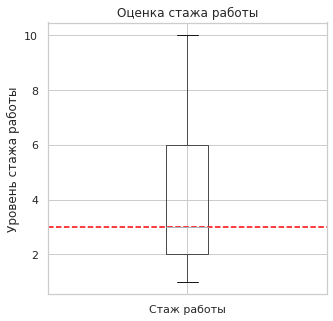

In [ ]:
# boxplot для employment_years
data_train[['employment_years']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_employment_years = np.median(data_train['employment_years'])
plt.axhline(median_employment_years, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_employment_years}')

# Добавляем подписи и заголовок
plt.title('Оценка стажа работы')
plt.ylabel('Уровень стажа работы')
plt.xticks([1], ['Стаж работы'])  # Подписываем ось X

# Показываем график
plt.show()

Большинство сотрудников имеют стаж работы от 2 до 6 лет.
Медиана стажа работы составляет 2,9 года.
Нижний квартиль (Q1) составляет 0,3 года - 25% сотрудников имеют стаж работы менее 0,3 года.
Верхний квартиль (Q3) составляет 10 лет - 75% сотрудников имеют стаж работы менее 10 лет.

Компания имеет относительно высокую текучесть кадров, что приводит к большому количеству сотрудников с небольшим стажем работы.
В компании может быть много новых проектов или инициатив, что приводит к найму большого количества новых сотрудников.
Компания может находиться в отрасли, где типичный стаж работы для сотрудников относительно низок.

Признак employment_years может быть полезным для прогнозирования текучести кадров, поскольку сотрудники с меньшим стажем работы, как правило, имеют более высокую вероятность увольнения. Также может быть полезен для понимания опыта и навыков сотрудников, т.к. сотрудники с большим стажем работы имеют более высокий уровень опыта и навыков.

# Оценка supervisor_evaluation

Медиана salary: 4.0


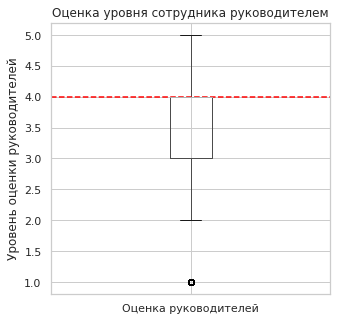

In [ ]:
# создаем boxplot для supervisor_evaluation
data_train[['supervisor_evaluation']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_supervisor_evaluation = np.median(data_train['supervisor_evaluation'])
plt.axhline(median_supervisor_evaluation, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_supervisor_evaluation}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня сотрудника руководителем')
plt.ylabel('Уровень оценки руководителей')
plt.xticks([1], ['Оценка руководителей'])  # Подписываем ось X

# Показываем график
plt.show()

In [ ]:
# Отберем сотрудников с оценкой руководителя 1,0
data_low_evaluation = data_train[data_train['supervisor_evaluation'] == 1.0]

# Выведем отобранные данные
display(data_low_evaluation)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
18,sales,middle,high,2,yes,no,1,50400,0.39
32,hr,senior,high,3,no,no,1,72000,0.22
45,technology,senior,high,3,no,no,1,84000,0.21
53,technology,junior,high,1,no,no,1,37200,0.10
...,...,...,...,...,...,...,...,...,...
3877,technology,junior,medium,3,no,no,1,30000,0.38
3949,technology,middle,medium,3,no,no,1,49200,0.39
3972,hr,middle,high,10,no,yes,1,57600,0.39
3988,sales,middle,low,8,no,no,1,22800,0.39


Большинство сотрудников получают положительные оценки от своих руководителей (большинство оценок в диапазоне от 3,0 до 4,0).
Медиана оценки составляет 4,0.
Нижний квартиль (Q1) составляет 3,0 - 25% сотрудников получают оценки ниже 3,0.
Верхний квартиль (Q3) составляет 5,0 - 75% сотрудников получают оценки ниже 5,0.
Есть выбросы на уровне 1,0 - сотрудники получили очень низкую оценку.

Руководители склонны давать своим подчиненным в целом положительные оценки.
Сотрудники могут в целом хорошо работать и получать положительные отзывы от своих руководителей.
Компания имеет систему оценки, которая поощряет положительные отзывы.

Признак supervisor_evaluation полезен для оценки производительности сотрудников и принятия решений о повышении по службе и бонусах, также для понимания динамики между руководителями и их подчиненными.

Выброс на уровне 1,0 может быть признаком проблемы, которую необходимо изучить. Руководители могут захотеть изучить причины этой низкой оценки и предпринять соответствующие действия.

In [ ]:
# Статистический анализ данных сотрудников с наименьшей оценкой руководителя
display(data_low_evaluation.describe())

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,201.000000,201.0,201.000000,201.000000
mean,3.601990,1.0,33122.388060,0.305423
std,2.457803,0.0,15382.520803,0.127789
min,1.000000,1.0,12000.000000,0.060000
25%,1.000000,1.0,22800.000000,0.200000
50%,3.000000,1.0,30000.000000,0.310000
75%,5.000000,1.0,40800.000000,0.380000
max,10.000000,1.0,92400.000000,0.580000


Средний стаж работы составляет 3,6 года.
Средняя зарплата составляет 33 122 рубля.
Средний уровень удовлетворенности работой составляет 0,31 (31%).

In [ ]:
# Выделим сотрудников с наименьшей оценкой руководителя
data_low_evaluation = data_train[data_train['supervisor_evaluation'] == 1.0]

# Анализ отделов, в которых чаще всего работают сотрудников с наименьшей оценкой руководителя
dept_counts = data_low_evaluation['dept'].value_counts()
print('Отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя:')
display(dept_counts)

# Анализ уровня сотрудников с наименьшей оценкой руководителя
level_counts = data_low_evaluation['level'].value_counts()
print('Уровень сотрудников с наименьшей оценкой руководителя:')
display(level_counts)

# Анализ уровня загруженности сотрудников с наименьшей оценкой руководителя
workload_counts = data_low_evaluation['workload'].value_counts()
print('Уровень загруженности у сотрудников с наименьшей оценкой руководителя:')
display(workload_counts)

# Анализ уровня Повышение в прошлом году сотрудников с наименьшей оценкой руководителя
last_year_promo_counts = data_low_evaluation['last_year_promo'].value_counts()
print('Повышение в прошлом году у сотрудников с наименьшей оценкой руководителя:')
display(last_year_promo_counts)

# Анализ уровня Нарушения дисциплины в прошлом году сотрудников с наименьшей оценкой руководителя
last_year_violations_counts = data_low_evaluation['last_year_violations'].value_counts()
print('Нарушения дисциплины в прошлом году у сотрудников с наименьшей оценкой руководителя:')
display(last_year_violations_counts)

# Сравнение средней зарплаты сотрудников с наименьшей оценкой руководителя с остальными
mean_salary_low_evaluation = data_low_evaluation['salary'].mean()
mean_salary_stayers = data_train[data_train['supervisor_evaluation'] == 1.0]['salary'].mean()

print(f'Средняя зарплата сотрудников с наименьшей оценкой руководителя: {mean_salary_low_evaluation}')
print(f'Средняя зарплата остальных сотрудников: {mean_salary_stayers}')

Отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя:


sales         67
purchasing    47
technology    41
marketing     23
hr            23
Name: dept, dtype: int64

Уровень сотрудников с наименьшей оценкой руководителя:


junior    98
middle    84
senior    19
Name: level, dtype: int64

Уровень загруженности у сотрудников с наименьшей оценкой руководителя:


medium    99
low       61
high      41
Name: workload, dtype: int64

Повышение в прошлом году у сотрудников с наименьшей оценкой руководителя:


no     194
yes      7
Name: last_year_promo, dtype: int64

Нарушения дисциплины в прошлом году у сотрудников с наименьшей оценкой руководителя:


no     151
yes     50
Name: last_year_violations, dtype: int64

Средняя зарплата сотрудников с наименьшей оценкой руководителя: 33122.388059701494
Средняя зарплата остальных сотрудников: 33122.388059701494


Отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя: sales, purchasing и technology.
Уровень загруженности у сотрудников с наименьшей оценкой руководителя: в основном средний (99 сотрудников) и низкий (61 сотрудник).
Средняя зарплата сотрудников с наименьшей оценкой руководителя и остальных сотрудников одинакова: 33 122,39 рубля.
Сотрудники с наименьшей оценкой руководителя не обязательно имеют более низкую зарплату или более высокую загруженность, чем остальные сотрудники, значит оценка руководителя может быть основана на других факторах, таких как производительность, поведение или отношение.
Самую низкую оценку руководителя имеют отрудники с уровнем junior и middle (98 и 84 соответственно), сотрудники sinior в разы меньше получают низкие оценки (19).
Из 201 сотрудников с наименьшей оценкой руководителя 194 не получали повышение в прошлом году, а 7 получили,  151 не имели нарушений дисциплины в прошлом году, а 50 имели.

Т.О. сотрудники с наименьшей оценкой руководителя, скорее всего, являются младшими и средними сотрудниками, у которых мало шансов на повышение или которые имеют нарушения дисциплины.
Также стоит отметить, что отделы с наибольшим количеством сотрудников с наименьшей оценкой руководителя являются отделами с наибольшим количеством сотрудников в целом, возможно в этих отделах более строгая система оценки, или в них работают более требовательные руководители.

# Оценка salary

Медиана salary: 30000.0


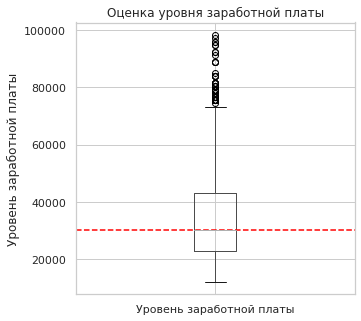

In [ ]:
# создаем boxplot для столбца salary
data_train[['salary']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_salary = np.median(data_train['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня заработной платы')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Уровень заработной платы'])  # Подписываем ось X

# Показываем график
plt.show()

Большинство сотрудников получают зарплату в диапазоне от 21 000 до 41 000.
Медиана зарплаты составляет 30 000.
Нижний квартиль (Q1) составляет 10 000 - 25% сотрудников получают зарплату в районе 10 000.
Верхний квартиль (Q3) составляет 75 000 - 75% сотрудников получают зарплату около 75 000.
Есть несколько выбросов на уровне от 76 000 до 100 000 - несколько сотрудников получают очень высокую зарплату.

Компания имеет широкий диапазон должностей с разным уровнем оплаты.
Сотрудники с большим стажем работы и опытом могут получать более высокую зарплату.
Компания может находиться в отрасли с высокими зарплатами.

Признак salary может быть полезным для понимания распределения заработной платы в компании, для прогнозирования затрат на персонал и принятия решений о компенсации.
Выбросы на уровне от 76 000 до 100 000 могут быть признаком проблемы, которую необходимо изучить. Руководители могут захотеть изучить причины этой высокой зарплаты и предпринять соответствующие действия.

In [ ]:
# Выделим сотрудников с зарплатой выше 75 000
data_high_salary = data_train[data_train['salary'] >= 75000]

# Анализ отделов, в которых чаще всего работают сотрудники с зарплатой выше 75 000
dept_counts = data_high_salary['dept'].value_counts()
print('Отделы с наибольшим количеством сотрудников с зарплатой выше 75 000:')
display(dept_counts)

# Анализ уровня сотрудников с зарплатой выше 75 000
level_counts = data_high_salary['level'].value_counts()
print('Уровень сотрудников с зарплатой выше 75 000:')
display(level_counts)

# Анализ уровня загруженности сотрудников с зарплатой выше 75 000
workload_counts = data_high_salary['workload'].value_counts()
print('Уровень загруженности у сотрудников с зарплатой выше 75 000:')
display(workload_counts)

# Анализ уровня Повышение в прошлом году сотрудников с зарплатой выше 75 000
last_year_promo_counts = data_high_salary['last_year_promo'].value_counts()
print('Повышение в прошлом году у сотрудников с зарплатой выше 75 000:')
display(last_year_promo_counts)

# Анализ уровня Нарушения дисциплины в прошлом году сотрудников с зарплатой выше 75 000
last_year_violations_counts = data_high_salary['last_year_violations'].value_counts()
print('Нарушения дисциплины в прошлом году у сотрудников с зарплатой выше 75 000:')
display(last_year_violations_counts)

# Сравнение средней зарплаты сотрудников с зарплатой выше 75 000 с остальными
mean_salary_high_salary = data_high_salary['salary'].mean()
mean_salary_stayers = data_train[data_train['salary'] < 75000]['salary'].mean()

print(f'Средняя зарплата сотрудников с зарплатой выше 75 000: {mean_salary_high_salary}')
print(f'Средняя зарплата остальных сотрудников: {mean_salary_stayers}')

Отделы с наибольшим количеством сотрудников с зарплатой выше 75 000:


technology    22
sales         12
marketing     11
purchasing     8
hr             6
Name: dept, dtype: int64

Уровень сотрудников с зарплатой выше 75 000:


senior    59
Name: level, dtype: int64

Уровень загруженности у сотрудников с зарплатой выше 75 000:


high    59
Name: workload, dtype: int64

Повышение в прошлом году у сотрудников с зарплатой выше 75 000:


no     54
yes     5
Name: last_year_promo, dtype: int64

Нарушения дисциплины в прошлом году у сотрудников с зарплатой выше 75 000:


no     50
yes     9
Name: last_year_violations, dtype: int64

Средняя зарплата сотрудников с зарплатой выше 75 000: 81864.40677966102
Средняя зарплата остальных сотрудников: 33209.03324029434


Отделы с наибольшим количеством сотрудников с зарплатой выше 75 000: технологический отдел -> отдел продаж -> маркетинга -> закупки -> hr, все сотрудники с зарплатой выше 75 000 имеют уровень "сеньор" и высокую загруженность (все 59 чел), большинство из них не получали повышения в прошлом году (54) и не имели нарушений дисциплины в прошлом году (50).
Средняя зарплата таких сотрудников в 2,5 раза выше, чем у остальных сотрудников.

Т.о., сотрудники с высокими зарплатами чаще всего работают в определенных отделах (технологии, продажи, маркетинг) и имеют высокий уровень опыта и загруженности. Они не получали повышение и не имели нарушения дисциплины в прошлом году.

In [ ]:
# Проверяем, являются ли числовые признаки непрерывными или дискретными
for col in data_train.select_dtypes(include=['number']).columns:
    if data_train[col].isna().any():
        print(f'{col} содержит пропущенные значения')
    elif col == 'salary':
        print(f'{col} непрерывный')  # Обозначаем 'salary' как непрерывный
    elif data_train[col].dtype == int:
        print(f'{col} дискретный')
    else:
        print(f'{col} непрерывный')

employment_years дискретный
supervisor_evaluation дискретный
salary непрерывный
job_satisfaction_rate непрерывный


Дискретные признаки обычно не требуют масштабирования или других преобразований.
Непрерывные признаки могут потребовать масштабирования или преобразования, чтобы привести их к единому масштабу и улучшить производительность модели. Непрерывные признаки также могут быть более подвержены влиянию выбросов, которые могут потребовать обработки.

# Обработка выбросов salary в data_train

In [ ]:
# Рассчитываем Q1 и Q3
Q1 = data_train['salary'].quantile(0.25)
Q3 = data_train['salary'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим среднее значение в пределах интерквартильного размаха
mean_value = data_train[(data_train['salary'] >= lower_bound) & (data_train['salary'] <= upper_bound)]['salary'].mean()

# Заменяем выбросы на среднее значение
data_train['salary'] = data_train['salary'].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

Медиана salary: 30000.0


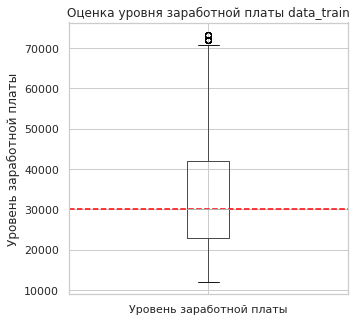

In [ ]:
# создаем boxplot для столбца salary
data_train[['salary']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_salary = np.median(data_train['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня заработной платы data_train')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Уровень заработной платы'])  # Подписываем ось X

# Показываем график
plt.show()

Преобразованы выбросы salary в data_train

# Обработка выбросов salary в data_test

Медиана salary: 30000.0


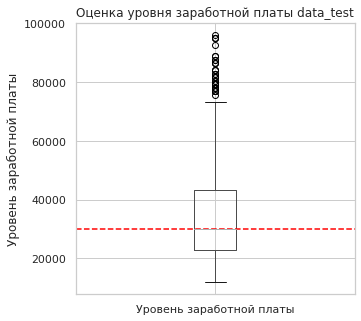

In [ ]:
# создаем boxplot для столбца salary data_test
data_test[['salary']].boxplot(figsize=(5, 5))

# помечаем медиану на графике
median_salary = np.median(data_test['salary'])
plt.axhline(median_salary, color='red', linestyle='--')

# выводим медиану
print(f'Медиана salary: {median_salary}')

# Добавляем подписи и заголовок
plt.title('Оценка уровня заработной платы data_test')
plt.ylabel('Уровень заработной платы')
plt.xticks([1], ['Уровень заработной платы'])  # Подписываем ось X

# Показываем график
plt.show()

Преобразованы выбросы salary в data_test чтобы улучшить производительность модели.

# Выводы о подготовке признаков в датафрейме

1. Изучены типы данных признаков, определено, являются ли признаки категориальными (номинальными или порядковыми) или числовыми (непрерывными или дискретными).  
Категориальные признаки: dept, level, workload_counts, last_year_promo, last_year_violations. 
Признаки dept и level имеют небольшое количество пропусков (15% и 10% соответственно), что не может сильно повлиять на анализ. Для признаков dept и level можно рассмотреть возможность заполнения пропущенных значений наиболее часто встречающимся значением или средним значением. Небольшое количество пропущенных значений в датафрейме не должно значительно повлиять на анализ или моделирование.

Числовые признаки: employment_years дискретный, supervisor_evaluation дискретный, salary дискретный, job_satisfaction_rate непрерывный. Дискретные признаки обычно не требуют масштабирования или других преобразований. Непрерывные признаки могут потребовать масштабирования или преобразования, чтобы привести их к единому масштабу и улучшить производительность модели. Непрерывные признаки также могут быть более подвержены влиянию выбросов, которые могут потребовать обработки. 

Показатели salary и supervisor_evaluation имели выбросы, которые были изучены и обработаны. Проведено их логарифмическое преобразование, чтобы уменьшить их влияние и сделать распределение более симметричным, привести их к одному масштабу, что полезно для сравнения наборов данных или признаков. Логарифмическое преобразование поможет стабилизировать дисперсию данных,  линеаризовать нелинейные отношения между признаками, что облегчает моделирование и интерпретацию, улучшит производительность линейной модели, что приведет к более точным прогнозам.

Деревья решений менее чувствительны к выбросам и нелинейным отношениям, поэтому логарифмическое преобразование может не потребоваться. Однако это может улучшить производительность модели, т.к. выбросы существенно отличаются от остальной части данных.

2. Проверены пропущенные значения, выявлены признаки с пропущенными значениями и оценена степень их влияния на анализ. Категориальные признаки: dept, level имеют небольшое количество пропусков (15% и 10% соответственно), что не может сильно повлиять на анализ. Для признаков dept и level можно рассмотреть возможность заполнения пропущенных значений наиболее часто встречающимся значением. Небольшое количество пропущенных значений в датафрейме не должно значительно повлиять на анализ или моделирование.

Категориальные признаки: Признаки dept, level, workload_counts, last_year_promo, last_year_violations должны быть закодированы с помощью меток или кодирования.
Числовые признаки: Признаки employment_years, supervisor_evaluation, salary, job_satisfaction_rate потребуют масштабирования для приведения их к единому масштабу.

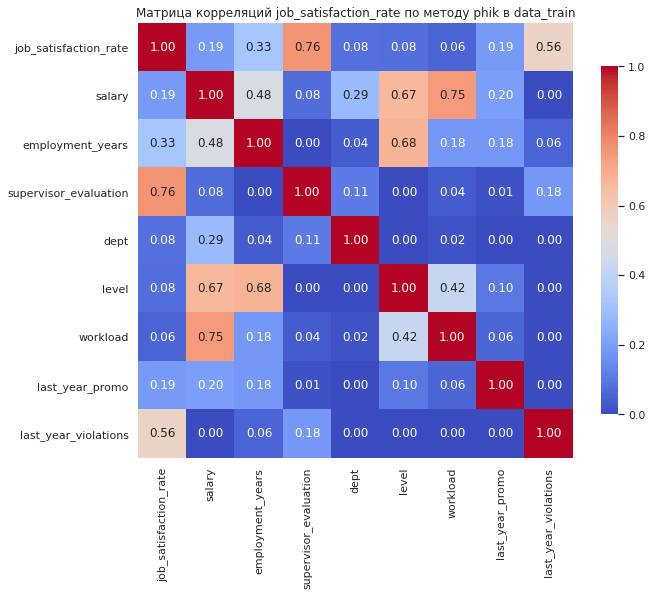

In [ ]:
# Определяем колонки, которые будем использовать data_train
# Интервальные (непрерывные признаки)
interval_cols = ['job_satisfaction_rate', 'salary']  # Непрерывные признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']  # Дискретные

# Создаем список всех признаков - union интервальных и дискретных
all_columns = data_train.columns.tolist()

# Убираем из всех столбцов интервальные, дискретные и id, чтобы получить категориальные
categorical_cols = [col for col in all_columns if col not in interval_cols + discrete_cols + ['id']]

# Выводим матрицу корреляций с использованием метода phik
# Указываем interval_cols для корректного расчета корреляций
correlation_matrix = phik_matrix(
    data_train[interval_cols + discrete_cols + categorical_cols],  # Передаем только интервальные и дискретные признаки
    interval_cols=interval_cols  # Указываем, какие признаки являются непрерывными
)

# Рисуем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций job_satisfaction_rate по методу phik в data_train')
plt.show()

1. Самые сильные корреляции - значение 0,76 указывает на сильную + связь между переменными supervisor_evaluation и job_satisfaction_rate, salary и workload. 0,72 указывают на сильную + связь между переменными salary и level, 0,68 - level и employment_years, 0,59 указывают на сильную + связь между переменными last_year_violations и job_satisfaction_rate. 

Высокие оценки со стороны руководства связаны с повышенным уровнем удовлетворенности сотрудников, значит работа, уровень зарплаты, высокая загрузка, признание и обратная связь от руководства играют ключевую роль в удовлетворении сотрудников. В компании более высокая должность, как правило, соответствует более высокой зарплате, что также логично. Повышение уровня должности, вероятно, также связано с увеличением лет работы в компании, что может указывать на карьерный рост.

Средняя корреляция 0,59 показывает, что предыдущие нарушения могут отрицательно сказываться на уровне удовлетворенности работой.

2. Отсутствие корреляции - значения, близкие к 0 указывают на отсутствие линейной связи между переменными, таких корреляций большинство, по целевому признаку job_satisfaction_rate к слабым относятся: dept (0,12), level (0,06), workload (0,06), last_year_promo (0,16) и даже salary (0,22) - переменные не связаны. 
salary никак не связан с last_year_violations (0) и supervisor_evaluation (0,09). 
supervisor_evaluation никак не связан с level, employment_years, last_year_promo, salary (0-0,1), очень слабая корреляция по этому признаку с dept, last_year_violations (0,11-0,18).
last_year_violations никак не связан с dept, level, workload, last_year_promo и salary (0),  employment_years (0,06), supervisor_evaluation (0,18).
last_year_promo никак не связан с dept, last_year_violations, supervisor_evaluation (0-0,01), employment_years, job_satisfaction_rate и salary 0,18-0,16,0,21 соответственно.
employment_years никак не связан с supervisor_evaluation - 0, с dept 0,04, с last_year_violations 0,06.
workload никак не связан с last_year_violations - 0, dept 0,02, supervisor_evaluation 0,04, last_year_promo и job_satisfaction_rate 0,06, employment_years 0,18, умеренно - level - 0,42.
level никак не связан с dept, last_year_violations и supervisor_evaluation - 0. job_satisfaction_rate - 0,06, last_year_promo - 0,1.

Низкие значения корреляции (близкие к 0) указывающие на слабую или отсутствующую взаимосвязь важны в бизнес-анализе, так как многие переменные, такие как уровень нагрузки, оценки супервайзера, и даже зарплата, не показывают сильной связи с другими переменными, такими как job_satisfaction_rate или last_year_violations.

Переменные, такие как dept, level, workload, и last_year_promo, имеют очень слабые корреляции с job_satisfaction_rate, что может указывать на то, что удудовлетворенность работой не зависит от этих факторов.

Employment Years и Supervisor Evaluation - низкая корреляция (0) говорит о том, что количество лет работы в компании не влияет на оценки от руководства, что может сигнализировать о необходимости пересмотреть систему оценки или карьерного роста.

Необходимо обратить внимание на удовлетворенность. Учитывая сильную связь между оценками супервайзеров и уровнем удовлетворенности, рекомендуется разработать подход к повышению качества обратной связи, а также обучению менеджеров на предмет эффективной оценки.
Если сотрудники с более высокой нагрузкой получают более высокую зарплату, компании следует протестировать систему оплаты труда, чтобы она более справедливо отражала вклад сотрудников.

# Анализ общего распределения признаков в data_test

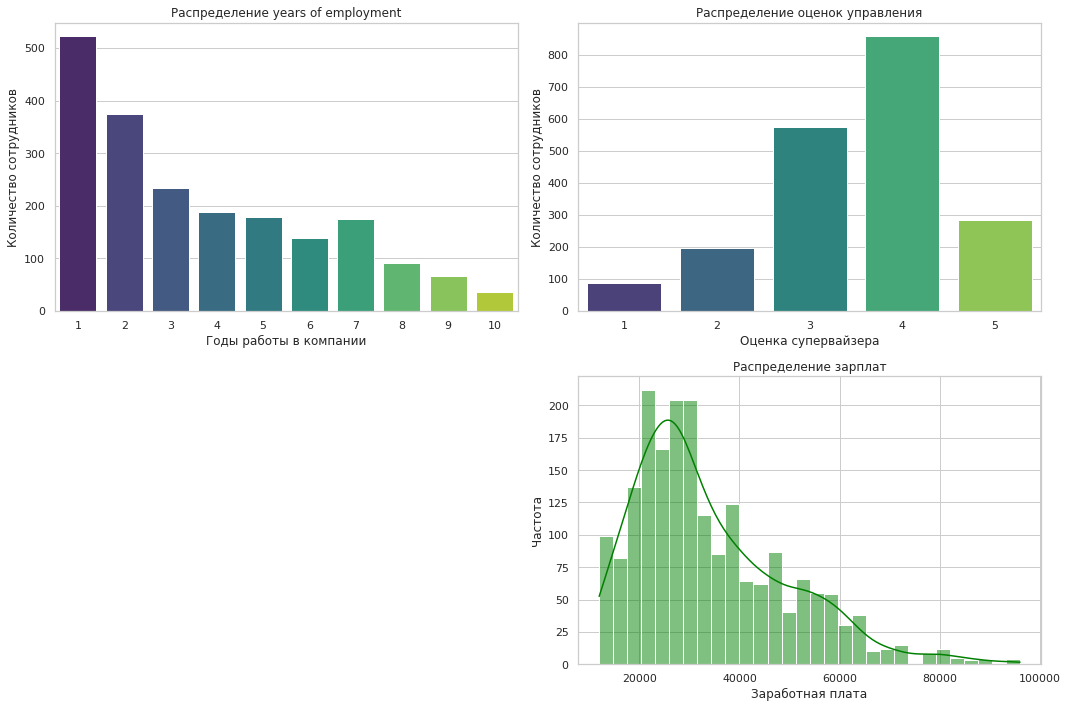

In [ ]:
# Устанавливаем стиль для графиков
sns.set(style="whitegrid")

# Создаем фигуру для графиков
plt.figure(figsize=(15, 10))

# Для дискретных признаков
plt.subplot(2, 2, 1)  # График 1: employment_years
sns.countplot(x='employment_years', data=data_test, palette='viridis')
plt.title('Распределение years of employment')  # Название графика
plt.xlabel('Годы работы в компании')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 2)  # График 2: supervisor_evaluation
sns.countplot(x='supervisor_evaluation', data=data_test, palette='viridis')
plt.title('Распределение оценок управления')  # Название графика
plt.xlabel('Оценка супервайзера')  # Подпись оси X
plt.ylabel('Количество сотрудников')  # Подпись оси Y

plt.subplot(2, 2, 4)  # График 4: salary
sns.histplot(data_test['salary'], bins=30, kde=True, color='green')
plt.title('Распределение зарплат')  # Название графика
plt.xlabel('Заработная плата')  # Подпись оси X
plt.ylabel('Частота')  # Подпись оси Y

plt.tight_layout()  # Улучшает внешний вид графиков
plt.show()

# Коэффициенты асимметрии
1.employment_years - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников с небольшим стажем, опытных сотрудников около 500 человек - сопоставимо с data_train.
2.supervisor_evaluation - левостороннее наклонное распределение (Большинство данных сгруппировано в правой части гистограммы, а хвост простирается влево). Большинство сотрудников имеют высокую оценку руководителя, у небольшой группы - очень низкая - сопоставимо с data_train.
3.salary - правостороннее наклонное распределение (большинство данных сгруппировано в левой части гистограммы, а хвост простирается вправо). Большинство сотрудников имеют низкую зарплату, у небольшой группы сотрудников высокая зарплата - сопоставимо с data_train.

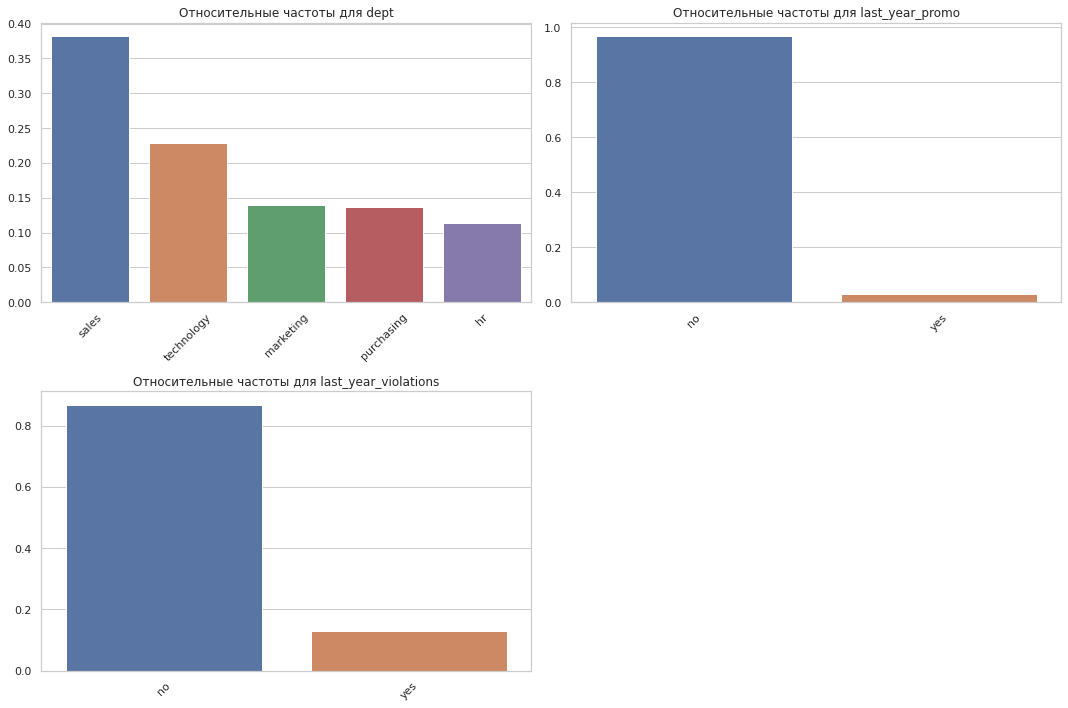

In [ ]:
# Категориальные признаки data_test в относительных показателях
categorical_cols = ['dept', 'last_year_promo', 'last_year_violations']

# Анализ и визуализация
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    # Получаем относительные частоты
    relative_freq = data_test[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

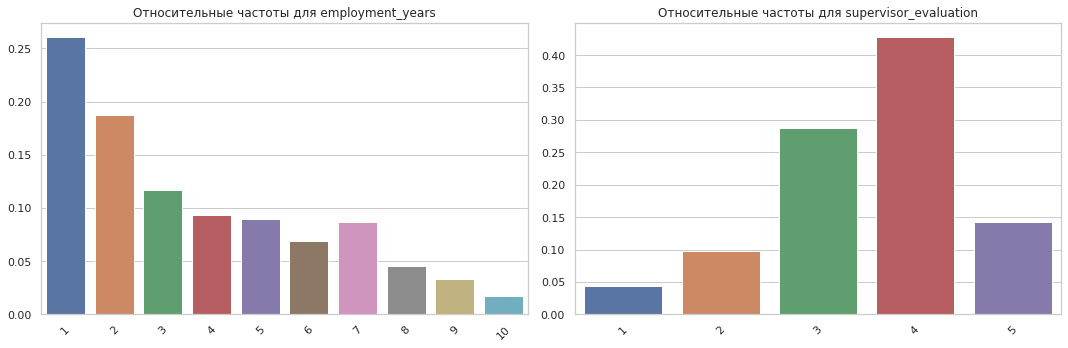

In [ ]:
# Дискретные признаки data_test в относительных показателях
discrete_cols = ['employment_years', 'supervisor_evaluation']

# Анализ и визуализация
plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(1, 2, i)
    # Получаем относительные частоты
    relative_freq = data_test[col].value_counts(normalize=True)
    # Визуализируем
    sns.barplot(x=relative_freq.index, y=relative_freq.values)
    plt.title(f'Относительные частоты для {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Распределение данных сопоставимо в data_test и data_train.

# Объединение тестовых данных data_test и data_target в data_merged

In [ ]:
# Объединяем тестовые данные data_test и data_target по столбцу 'id'
data_merged = pd.merge(data_test, data_target, on='id')

# Вывод объединенного DataFrame
display(data_merged)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [ ]:
print(data_merged.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [ ]:
# Проверяем наличие дубликатов
duplicates = data_merged.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(data_merged[duplicates])

Количество дубликатов в данных: 0


In [ ]:
display(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


None

In [ ]:
# Получаем уникальные значения для категориальных признаков data_merged
for col in data_merged.select_dtypes(include=['object']).columns:
    print(f"Уникальные значения для столбца {col}:")
    print(data_merged[col].unique())
    display()

Уникальные значения для столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для столбца level:
['junior' 'middle' 'senior' nan]
Уникальные значения для столбца workload:
['medium' 'low' 'high' nan]
Уникальные значения для столбца last_year_promo:
['no' 'yes']
Уникальные значения для столбца last_year_violations:
['no' 'yes']


In [ ]:
display(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


None

# Распределение удовлетворенности работой по отделам и уровням в тестовой группе

In [ ]:
# Создаем сводную таблицу для распределения удовлетворенности работой по отделам и уровням
pivot_table = pd.pivot_table(
    data_merged,
    values='job_satisfaction_rate',  # Столбец с удовлетворенностью
    index='dept',                     # Индекс - отдел
    columns='level',                  # Столбцы - уровни
    aggfunc='mean',                   # Функция агрегации - среднее значение
    fill_value=0                      # Заменяем NaN на 0
)

# Выводим сводную таблицу
print("Сводная таблица по удовлетворенности работой в тестовой группе:")
display(pivot_table)

Сводная таблица по удовлетворенности работой в тестовой группе:


level,junior,middle,senior
dept,,,
hr,0.528974,0.561538,0.588421
marketing,0.570310,0.540229,0.611579
purchasing,0.550373,0.539664,0.629500
sales,0.534053,0.571389,0.617302
technology,0.507834,0.535000,0.605200


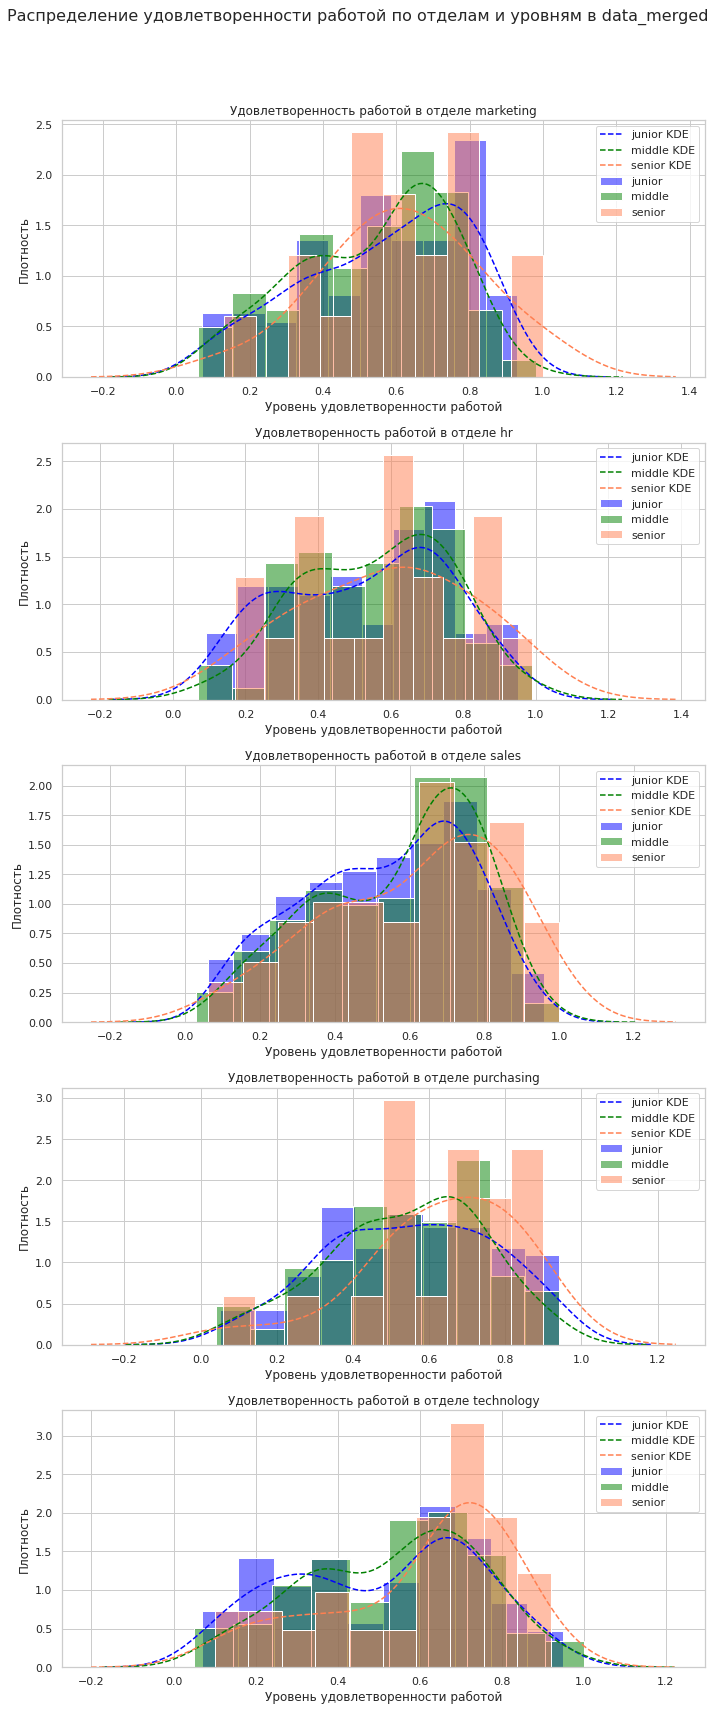

In [ ]:
# Цвета для уровней
level_colors = {'junior': 'blue', 'middle': 'green', 'senior': 'coral'}  

# Уникальные отделы, исключая NaN
departments = data_merged['dept'].dropna().unique()

# Создаем фигуру с подграфиками
fig, axes = plt.subplots(nrows=len(departments), ncols=1, figsize=(10, 5 * len(departments)))

# Проходим по каждому отделу и создаем нормированные гистограммы
for ax, dept in zip(axes, departments):
    # Группируем данные по уровням для текущего отдела
    for level in data_merged['level'].unique():
        if pd.isna(level):  # Пропускаем NaN значения
            continue
        group = data_merged[(data_merged['dept'] == dept) & (data_merged['level'] == level)]
        
        # Используем нормированную гистограмму
        sns.histplot(group['job_satisfaction_rate'].dropna(), 
                     bins=10, 
                     stat='density', 
                     common_norm=False,
                     alpha=0.5, 
                     label=level, 
                     color=level_colors[level], 
                     ax=ax)
        
        # Также можно добавить график плотности
        sns.kdeplot(group['job_satisfaction_rate'].dropna(), 
                    color=level_colors[level], 
                    ax=ax, 
                    label=f'{level} KDE', 
                    linestyle='--')

    # Настраиваем оси и заголовок для каждого отдела
    ax.set_title(f'Удовлетворенность работой в отделе {dept}')
    ax.set_xlabel('Уровень удовлетворенности работой')
    ax.set_ylabel('Плотность')
    ax.legend()

# Настраиваем общий заголовок для всей фигуры
plt.suptitle('Распределение удовлетворенности работой по отделам и уровням в data_merged', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Убираем перекрытие заголовка

# Отображаем гистограммы
plt.show()

Уровень удовлетворенности в тестовой группе также варьируется в зависимости от отдела и уровня должности, как и в data_train. В целом, удовлетворенность работой у сотрудников senior уровня выше, чем у junior и middle, что может указывать на то, что более опытные сотрудники имеют более позитивный опыт работы.

Отдел HR:

   • Удовлетворенность работой на уровне junior (0.529) является самой низкой среди всех уровней, но постепенно увеличивается на уровнях middle (0.562) и senior (0.588). HR-отделу стоит обратить внимание на условия работы и возможности для роста для младших специалистов - обратная зависимость в отличие от data_train.

Отдел Marketing:

   • В маркетинговом отделе наблюдается высокая удовлетворенность на уровне junior (0.570), но уровень middle (0.540) ниже, чем у junior, и только senior (0.612) показывает высокий уровень удовлетворенности - средние специалисты сталкиваются с определенными трудностями или недостатком поддержки. Также обратная зависимость по сравнению с data_train.

Отдел Purchasing:

   • В purchasing уровне junior (0.550) и middle (0.540) показывают схожие результаты, но senior уровень (0.630) значительно выше, значит с ростом в должности сотрудники получают больше возможностей для удовлетворения своих профессиональных потребностей. В data_train показатели немного ниже, но более сбаллансированы и нет перекоса в какую-либо сторону, отдел демонстрирует позитивную рабочую атмосферу.

Отдел Sales:

   • В sales отделе наблюдается стабильный рост удовлетворенности от junior (0.534) до senior (0.617) - отдел предоставляет хорошие условия для роста и развития сотрудников. В data_train имеется характерный дисбалланс в отношении senior сотрудников, которые существенно ущемлены в этом отношении и являются самой неудовлетворенной группой среди всех отделов.

Отдел Technology:

   • В technology отделе уровень удовлетворенности самый низкий среди junior (0.508) и middle (0.535), но senior уровень (0.605) все же показывает более положительные результаты. Это может указывать на необходимость улучшения условий работы для младших и средних специалистов, чтобы повысить их удовлетворенность. В data_train также показатели немного ниже, но более сбаллансированы и нет перекоса в какую-либо сторону.
   
В целом выборки несколько отличаются по динамике показателей.

# Матрица корреляций job_satisfaction_rate по методу phik в объединенной тестовой выборке data_merged

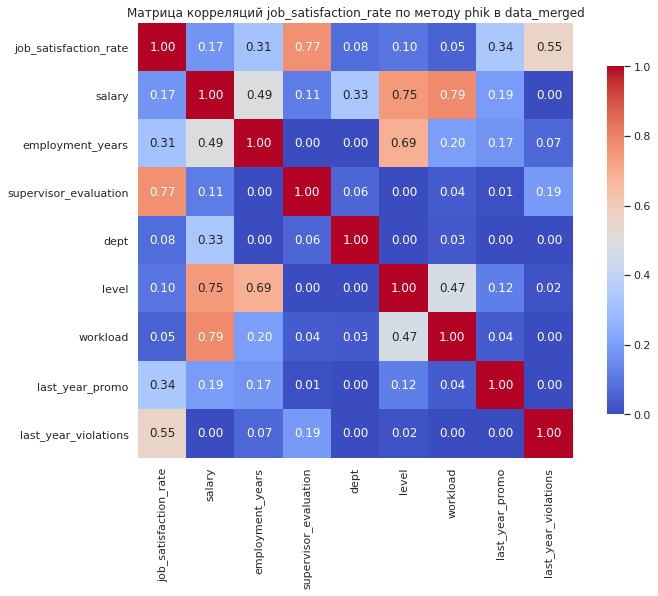

In [ ]:
# Определяем колонки, которые будем использовать
# Интервальные (не коррелирующие: employment_years и supervisor_evaluation)
interval_cols = ['job_satisfaction_rate', 'salary']  # Непрерывные признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']  # Дискретные

# Создаем список всех признаков - union интервальных и дискретных
all_columns = data_merged.columns.tolist()

# Убираем из всех столбцов интервальные, дискретные и id, чтобы получить категориальные
categorical_cols = [col for col in all_columns if col not in interval_cols + discrete_cols + ['id']]

# Выводим матрицу корреляций с использованием метода phik
# Указываем interval_cols для корректного расчета корреляций
correlation_matrix = data_merged[interval_cols + discrete_cols + categorical_cols].phik_matrix(interval_cols=interval_cols)

# Рисуем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций job_satisfaction_rate по методу phik в data_merged')
plt.show()

В целом данные сопоставимы с data_train

In [ ]:
display(data_merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


None

In [ ]:
print(data_merged.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [ ]:
# Проверяем наличие дубликатов
duplicates = data_merged.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных: {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(data_merged[duplicates])

Количество дубликатов в данных: 0


In [ ]:
# Проверим наличие строк с некорректным значением в data_train
idx = data_merged[data_merged['job_satisfaction_rate'] == 'sales'].index

# Выведем эти строки на экран
print(data_merged.loc[idx])

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []


In [ ]:
print(data_merged['job_satisfaction_rate'].dtype)

float64


In [ ]:
print(data_merged['job_satisfaction_rate'].isna().sum())

0


# Шаг 4. Подготовка данных

Подготовку признаков выполните в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика

In [ ]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   float64
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 281.4+ KB


None

In [ ]:
print(data_train.columns.tolist())

['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


In [ ]:
# Проверяем наличие дубликатов
duplicates = data_train.duplicated()

# Выводим количество дубликатов
num_duplicates = duplicates.sum()
print(f"Количество дубликатов в данных после удаления 'id': {num_duplicates}")

# Выводим дубликаты
if num_duplicates > 0:
    print("Дубликаты:")
    display(data_train[duplicates])

Количество дубликатов в данных после удаления 'id': 245
Дубликаты:


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
437,purchasing,junior,low,1,no,no,4,15600.0,0.61
502,sales,middle,low,7,no,no,4,28800.0,0.77
520,sales,junior,medium,1,no,no,4,21600.0,0.43
676,sales,junior,medium,1,no,no,3,24000.0,0.34
784,sales,junior,medium,1,no,no,5,21600.0,0.44
...,...,...,...,...,...,...,...,...,...
3969,sales,middle,medium,3,no,no,4,33600.0,0.47
3984,technology,junior,low,2,no,no,4,15600.0,0.68
3989,sales,middle,low,3,no,no,3,22800.0,0.18
3995,technology,junior,high,2,no,no,3,46800.0,0.45


In [ ]:
# Удаляем дубликаты
data_train.drop_duplicates(inplace=True)

# Проверяем количество дубликатов после удаления
num_duplicates_after = data_train.duplicated().sum()
print(f"Количество дубликатов после удаления: {num_duplicates_after}")

Количество дубликатов после удаления: 0


In [ ]:
# Проверим наличие строк с некорректным значением в data_train
idx = data_train[data_train['job_satisfaction_rate'] == 'sales'].index

# Выведем эти строки на экран
print(data_train.loc[idx])

Empty DataFrame
Columns: [dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []


In [ ]:
print(data_train['job_satisfaction_rate'].dtype)

float64


In [ ]:
print(data_train['job_satisfaction_rate'].isna().sum())

0


In [ ]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   float64
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 422.4+ KB


None

3755 наблюдений в обучающей выборке можно считать ограниченным набором данных, учитывая количество признаков и сложность задачи (предсказание удовлетворенности работой), необходимо использовать валидационную выборку, которая поможет оценить производительность модели на невиданных ранее данных и предотвратить переобучение. Валидационная выборка предоставит дополнительный набор данных для оценки производительности модели, поможет настроить гиперпараметры модели и выбрать модель, которая лучше всего подходит для данных. Можно выделить небольшую часть (20%) в качестве валидационной выборки, оставив 80% для обучающей выборки. Это обеспечит достаточное количество данных для обучения и оценки производительности модели.

Предоставлены данные: обучающий набор (`data_train`), тестовый набор (`data_merged`) Используем:
- `data_train` для обучения моделей,
- `data_merged` для оценки качества моделей.

In [ ]:
# Определим числовые, порядковые и категориальные колонки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']  # Категориальные признаки
ord_columns = ['level', 'workload']  # Порядковые признаки
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']  # Числовые признаки

# Создание пайплайна для предобработки признаков с учетом обработки пропусков
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Игнорируем неизвестные категории
        ]), ohe_columns),
        ('ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков модой
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Кодируем неизвестные значения
        ]), ord_columns),
        ('scale', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков средним
            ('scaler', StandardScaler())
        ]), num_columns)
    ]
)

In [ ]:
# Создание пайплайнов для линейной регрессии и дерева решений
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=123))  # Установка random_state для воспроизводимости
])

Проведена подготовка признаков в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учтены особенности признаков: числовые (StandardScaler), порядковые (OrdinalEncoder), категориальные (OneHotEncoder) и моделей LinearRegression и DecisionTreeRegressor, использовано три кодировщика.

# Шаг 5. Обучение моделей

Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. 
Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 
Метрика SMAPE вычисляется так:
SMAPE=100n∑i=1n∣yi−yi^∣(∣yi∣+∣y^i∣)/2,SMAPE=n100∑i=1n(∣yi∣+∣y^i∣)/2∣yi−yi^∣,
где:
•	yiyi — фактическое значение целевого признака для объекта с порядковым номером ii в выборке;
•	yi^yi^ — предсказанное значение целевого признака для объекта с порядковым номером ii в выборке;
•	nn — количество объектов в выборке;
•	∑i=1n∑i=1n — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от ii до nn в выборке.
Напишите функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. Используйте эту метрику при подборе гиперпараметров и оценке качества моделей. 
Критерий успеха: SMAPE ≤15≤15 на тестовой выборке.
В решении сохраните работу со всеми моделями, которые вы пробовали. Сделайте выводы

Обучение 2 моделей LinearRegression, DecisionTreeRegressor.

In [ ]:
# Определяем целевую переменную и признаки
X = data_train.drop(columns=['job_satisfaction_rate'])  # Признаки
y = data_train['job_satisfaction_rate']  # Целевая переменная

# Создадим пайплайн для линейной регрессии
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Создадим пайплайн для дерева решений
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [ ]:
# Функция для расчета sMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.clip(denominator, 1e-10, None)  # Избегаем деления на ноль
    return 100 * np.mean(np.abs(y_true - y_pred) / denominator)

# Создаем scorer для кросс-валидации
smape_scorer = make_scorer(smape, greater_is_better=False)

# Кросс-валидация для линейной регрессии с использованием sMAPE
lin_reg_cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring=smape_scorer)
lin_reg_cv_smape = -lin_reg_cv_scores.mean()  # Инвертируем, так как greater_is_better=False

# Кросс-валидация для дерева решений с использованием sMAPE
tree_reg_cv_scores = cross_val_score(tree_model, X, y, cv=5, scoring=smape_scorer)
tree_reg_cv_smape = -tree_reg_cv_scores.mean()  # Инвертируем, так как greater_is_better=False

# Вывод результатов кросс-валидации
print("Linear Regression sMAPE (Cross-Validation): ", lin_reg_cv_smape)
print("Decision Tree sMAPE (Cross-Validation): ", tree_reg_cv_smape)

Linear Regression sMAPE (Cross-Validation):  26.982802747673354
Decision Tree sMAPE (Cross-Validation):  15.97975506209933


Decision Tree показала значительно лучшее качество предсказаний по сравнению с Linear Regression - sMAPE на 11 пунктов ниже, значит она лучше справляется с задачей предсказания целевой переменной. sMAPE Decision Tree = 15.98 - средняя ошибка предсказаний составляет около 16% от фактических значений. Критерий успеха: sMAPE ≤ 15, Decision Tree близок к этому критерию, но не достигает его. Необходимо провести подбор гиперпараметров для Decision Tree.

In [ ]:
# Подбор гиперпараметров для дерева решений
param_grid = {
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__min_samples_split': [2, 5, 10]
}

# Настройка GridSearchCV
grid_search_tree = GridSearchCV(tree_model, param_grid, scoring=smape_scorer, cv=5)

# Обучение модели с помощью GridSearchCV
grid_search_tree.fit(X, y)

# Лучшая модель
best_tree_model = grid_search_tree.best_estimator_

# Вывод лучших параметров и результата кросс-валидации
print("Лучшие параметры для дерева решений:", grid_search_tree.best_params_)
print("Лучший результат кросс-валидации (sMAPE):", abs(grid_search_tree.best_score_))

Лучшие параметры для дерева решений: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}
Лучший результат кросс-валидации (sMAPE): 15.367592162455741


Лучшие гиперпараметры:
max_depth: None (дерево может расти до тех пор, пока не разделит все данные или не достигнет других ограничений).
min_samples_leaf: 1 (каждый лист должен содержать минимум 1 ответвление).
min_samples_split: 5 (для разделения узла требуется минимум 5 ответвлений).

Модель склонна к созданию достаточно глубокого дерева с минимальными ограничениями на размер листьев и узлов, что может привести к хорошему качеству на обучающих данных, но также увеличивает риск переобучения.

Проверяем качество модели после получения лучших параметров, обучаем модель с этими параметрами на всей тренировочной выборке и оцениваем ее качество на тестовой выборке с использованием метрики sMAPE.

In [ ]:
# Выбор лучшей модели на основе кросс-валидации
if lin_reg_cv_smape < abs(grid_search_tree.best_score_):
    best_model = linear_model
    print("Лучшая модель: Linear Regression")
else:
    best_model = best_tree_model
    print("Лучшая модель: Decision Tree")

# Оценка лучшей модели на тестовой выборке
X_test = data_merged.drop(columns=['id', 'job_satisfaction_rate'])  # Убираем 'id' и целевую переменную
y_test = data_merged['job_satisfaction_rate']  # Целевая переменная для теста

# Предсказание на тестовой выборке
y_test_pred = best_model.predict(X_test)

# Расчет sMAPE для тестовой выборки
sMAPE_test = smape(y_test, y_test_pred)

print("sMAPE на тестовой выборке для лучшей модели:", sMAPE_test)

Лучшая модель: Decision Tree
sMAPE на тестовой выборке для лучшей модели: 14.18307934720806


Дерево решений: sMAPE на тренировочной выборке: 15.36, sMAPE на тестовой выборке: 14.18. Модель показывает хорошее качество предсказаний и обобщается на тестовых данных.

In [ ]:
# Создаем константную модель для предсказания среднего значения целевой переменной
dummy_model = DummyRegressor(strategy="mean")

# Кросс-валидация для константной модели с использованием sMAPE
dummy_cv_scores = cross_val_score(dummy_model, X, y, cv=5, scoring=smape_scorer)
dummy_cv_smape = -dummy_cv_scores.mean()  # Инвертируем, так как greater_is_better=False

# Вывод результата кросс-валидации
print("Константная модель sMAPE (Cross-Validation): ", dummy_cv_smape)

Константная модель sMAPE (Cross-Validation):  40.19026456683123


Константная модель показывает качество хуже, чем LinearRegression и DecisionTreeRegressor, значает, что усилия по созданию признаков, настройке гиперпараметров и обучению моделей были оправданы.

# Шаг 6. Оформление выводов

Промежуточные выводы о том, какая модель справилась лучше и почему.

Модель дерева решений является более подходящей моделью для данных, показывает лучшую производительность, может быть использовано в дальнейшем анализе или для построения прогноза, так как оно более точно отражает зависимость между переменными.